In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.vision.data import *
import scipy.io as sio

# Getting data from Kaggle
https://www.kaggle.com/twopothead/miml-image-data

Install the official kaggle-cli, or download the data from the above url and extract them

In [ ]:
# ! pip install kaggle --upgrade
# ! mkdir -p ~/.kaggle/
# ! mv kaggle.json ~/.kaggle/ # Get your kaggle.json from your profile

In [3]:
path = Config.data_path()/'miml'
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/Users/phenomax/.fastai/data/miml')

In [4]:
!kaggle datasets download -p {path} twopothead/miml-image-data

miml-image-data.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
path = path/'miml-image-data'
images = path/'original'

In [ ]:
images.ls()

## Process matlab data file

In [6]:
mat = sio.loadmat(path/'miml data.mat')

In [7]:
mappings = {0: 'desert', 1: 'mountauns', 2: 'sea', 3: 'sunset', 4: 'trees'}

In [8]:
mat['targets'].shape

(5, 2000)

In [9]:
df = pd.DataFrame(mat['targets'])
df.index = ['desert', 'mountains', 'sea', 'sunset', 'trees']

In [10]:
df = df.applymap(lambda x: x == 1)
df

,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
desert,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
mountains,False,False,False,True,False,False,True,False,False,True,...,False,False,False,False,False,False,False,False,False,False
sea,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
sunset,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
trees,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True


In [11]:
def get_labels(path):
    match = re.search(r'\d+.jpg', str(path)).group()
    match = match.replace('.jpg', '')
    labels = ''
    
    match = df[int(match) - 1] # df starts at 0

    return [mappings[label] for label in mappings if match[label]]

In [12]:
get_labels('C:/any/12/path/9.jpg')

['desert']

In [13]:
tfms = get_transforms(max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [14]:
np.random.seed(42)

In [15]:
src = ImageList.from_folder(images).split_by_rand_pct(0.2).label_from_func(get_labels)

Adjust bs (batch size) based on your available GPU memory

In [17]:
data = (src.transform(tfms, size=128)
        .databunch(bs=6).normalize(imagenet_stats))

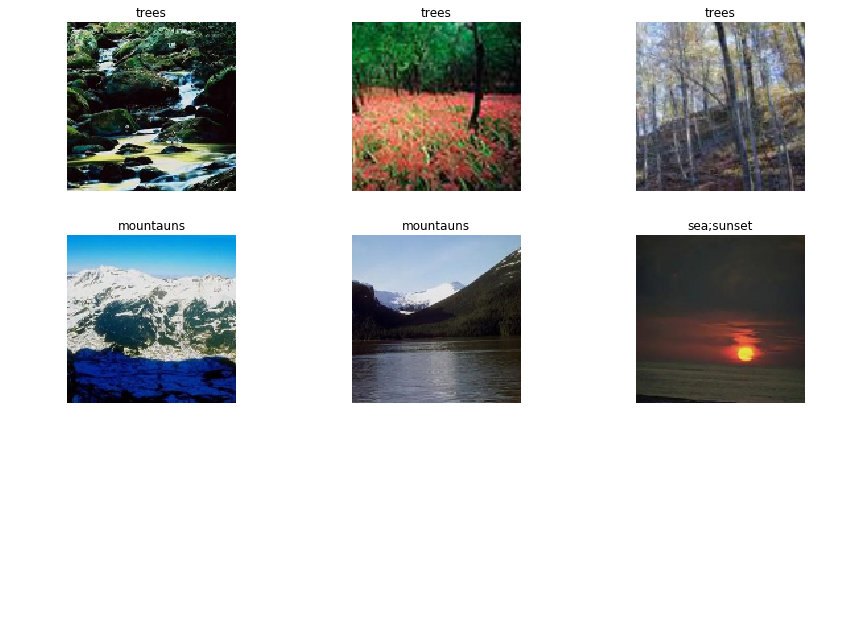

In [18]:
data.show_batch(rows=3, figsize=(12,9))

In [19]:
arch = models.resnet50

## 128x128 image size

In [20]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, arch, metrics=[acc_02, f_score])

In [21]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


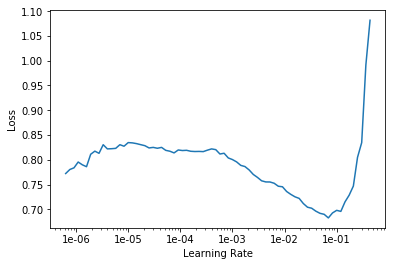

In [22]:
learn.recorder.plot()

In [23]:
lr = 0.01

In [24]:
learn.fit_one_cycle(8, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.402716,0.269021,0.843108,0.821736,00:08
1,0.365534,0.272682,0.858647,0.815432,00:07
2,0.345001,0.229947,0.888722,0.861893,00:07
3,0.330379,0.281224,0.871679,0.836191,00:07
4,0.291980,0.964310,0.857644,0.856037,00:07
5,0.302228,0.550823,0.868672,0.849196,00:07
6,0.264768,1.170533,0.871679,0.858208,00:07
7,0.271975,0.385951,0.889223,0.866972,00:07


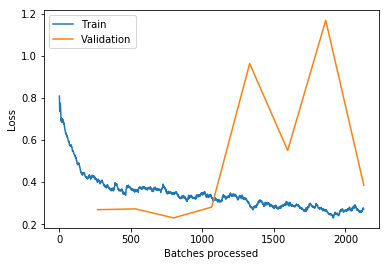

In [25]:
learn.recorder.plot_losses()

In [26]:
learn.save('stage-1-rn50')

In [27]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


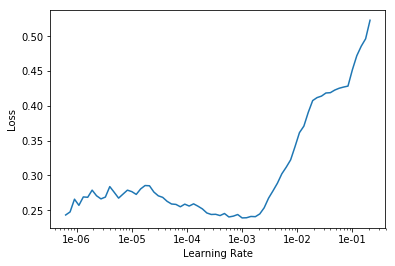

In [28]:
learn.lr_find()
learn.recorder.plot()

In [34]:
learn.fit_one_cycle(4, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.256558,0.551378,0.884211,0.868442,00:07
1,0.283416,0.470856,0.872682,0.850966,00:07
2,0.253234,0.423663,0.883709,0.867294,00:07
3,0.249777,0.417110,0.893233,0.869144,00:07


In [35]:
learn.save('stage-2-rn50')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


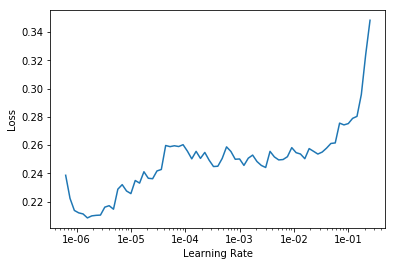

In [36]:
learn.lr_find()
learn.recorder.plot()

## Use 256x256 data

In [37]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, arch, metrics=[acc_02, f_score])

In [38]:
learn.load('stage-2-rn50')

Learner(data=ImageDataBunch;

Train: LabelList (1600 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: MultiCategoryList
desert;mountauns,sea,sea;sunset,desert,desert
Path: /Users/phenomax/.fastai/data/miml/miml-image-data/original;

Valid: LabelList (399 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: MultiCategoryList
sea,sea,trees,mountauns,sea;sunset
Path: /Users/phenomax/.fastai/data/miml/miml-image-data/original;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), s

In [39]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 128, 128])

In [40]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


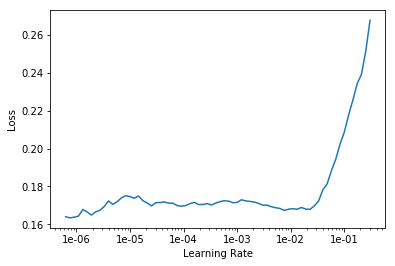

In [41]:
learn.lr_find()
learn.recorder.plot()

In [42]:
learn.unfreeze()

In [43]:
learn.fit_one_cycle(4, slice(1e-4, 3e-3))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.174119,13.299085,0.851128,0.808613,00:07
1,0.168345,0.220163,0.908772,0.877016,00:06
2,0.143376,0.162061,0.921804,0.901059,00:06
3,0.114263,0.151032,0.927318,0.913326,00:06


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


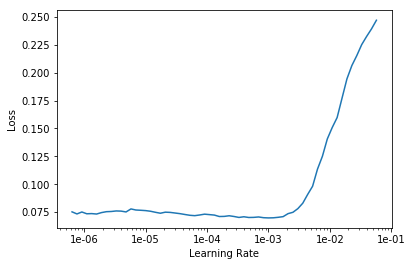

In [44]:
learn.lr_find()
learn.recorder.plot()

In [45]:
learn.save('stage-3-rn50-256')

In [46]:
learn.fit_one_cycle(4, slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.071038,0.154852,0.928321,0.915156,00:06
1,0.066647,0.167314,0.930326,0.919711,00:06
2,0.064463,0.172255,0.930326,0.920210,00:06
3,0.062852,0.212467,0.931328,0.918179,00:06


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


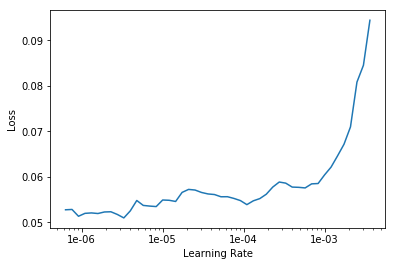

In [47]:
learn.lr_find()
learn.recorder.plot()

In [48]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


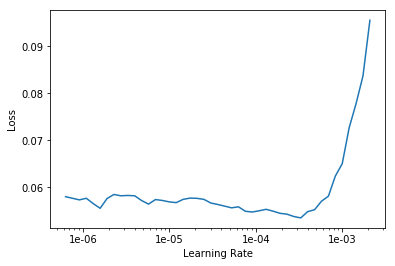

In [49]:
learn.lr_find()
learn.recorder.plot()

In [50]:
learn.fit_one_cycle(6, slice(1e-5, 5e-4))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.055169,0.208102,0.934336,0.920686,00:06
1,0.053615,0.266758,0.930326,0.915047,00:06
2,0.048723,0.269223,0.938847,0.925505,00:06
3,0.046144,0.179245,0.934336,0.921179,00:06
4,0.039848,0.271003,0.935338,0.922317,00:06
5,0.035818,0.274289,0.935338,0.922635,00:06


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


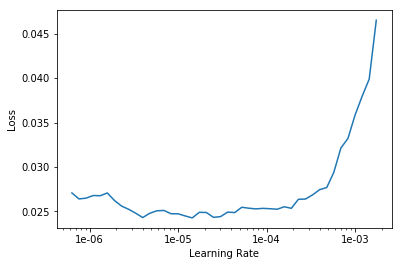

In [51]:
learn.lr_find()
learn.recorder.plot()

In [52]:
learn.save('stage-4-rn50-256')

## Comparison with paper 
http://cs.nju.edu.cn/zhouzh/zhouzh.files/publication/nips06.pdf

Although we are evaluating our results with a different function ([F1 score](https://en.wikipedia.org/wiki/F1_score)), our results (accuracy of ~93.5%, fbeta of ~92,2%) looks decent

![MIML Boost](assets/miml.png)

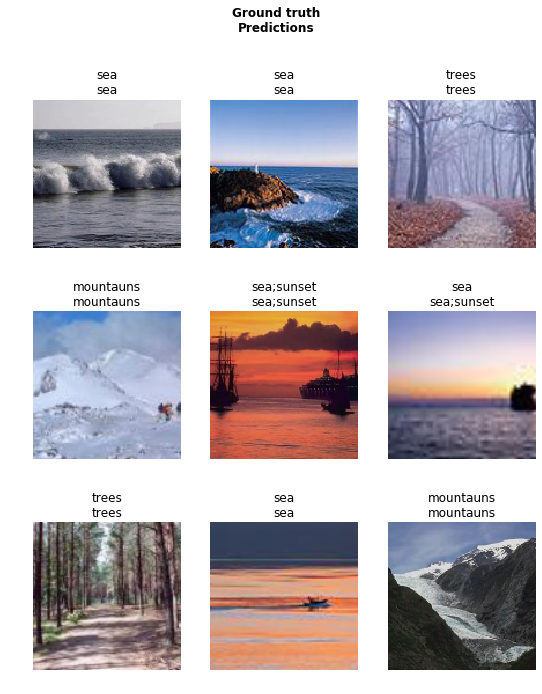

In [53]:
learn.show_results(rows=3, figsize=(9,11))

In [56]:
print(learn.summary())

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [1, 64, 64, 64]      9,408      True      
______________________________________________________________________
BatchNorm2d          [1, 64, 64, 64]      128        True      
______________________________________________________________________
ReLU                 [1, 64, 64, 64]      0          False     
______________________________________________________________________
MaxPool2d            [1, 64, 32, 32]      0          False     
______________________________________________________________________
Conv2d               [1, 64, 32, 32]      4,096      True      
______________________________________________________________________
BatchNorm2d          [1, 64, 32, 32]      128        True      
______________________________________________________________________
Conv2d               [1, 64, 32, 32]      36,864     True      
______________________________________________________________

In [55]:
learn.export(path/'weights.pkl')